## Animation

This notebook is fro creating animation from timeeries of NAO indices, SST, surface heat flux anomaly etc. data. 

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    ax.add_feature(cfeature.LAND) #facecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig, cb 

In [3]:
# Read Data for a fixed indices

tim_ind = 4

ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/time_series/NAO/"

ds_NAOp = xr.open_mfdataset(ppdir + "JFM_ind_" + str(tim_ind) + "/*NAOp*.nc")

ds_NAOn = xr.open_mfdataset(ppdir + "JFM_ind_" + str(tim_ind) + "/*NAOn*.nc")

tauu_NAOp = xr.open_mfdataset(ppdir + "JFM_ind_" + str(tim_ind) + "/*NAOp_tauu.nc")
tauu_NAOn = xr.open_mfdataset(ppdir + "JFM_ind_" + str(tim_ind) + "/*NAOn_tauu.nc")

print(ds_NAOp)

OSError: no files to open

In [4]:
ds_NAOp['time.month']

<xarray.DataArray 'month' (time: 125)>
array([11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3])
Coordinates:
  * time     (time) object 1960-11-16 00:00:00 ... 1971-03-16 00:00:00

### NAO indices

We isolate the NAO indices for the timeseries.  

In [4]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

NAO_season = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

In [5]:
NAO_cut = 2.5
tim_ind =4

NAOp = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind).drop('time') >= NAO_cut)

NAOn = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind).drop('time') <= -NAO_cut)

#print(NAOp)

### Combine data for NAO extremes with multiple DJF season

For better stats, we isolate members that had NAO >=2.5 (<=-2.5) at tim_ind = 4, 8, 12. We then combine them together (with shifted timelines, so NAO extremes are aligned) and consider only years -1 to 7.

In [6]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/time_series/NAO/"

ds_NAOp = []
ds_NAOn = []
tauu_NAOp = []
tauu_NAOn = []

var_list = ['tos', 'sos', 'hfds', 'mlotst']
var_list_atmos = ['tauu']

NAO_cut = 2.5

count_NAOp = 0
count_NAOn = 0

for ind in range(4,13,4):
    
    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    count_NAOp =  count_NAOp + c_NAOp
    count_NAOn =  count_NAOn + c_NAOn
    
    d_NAOp = xr.open_mfdataset(ppdir + "*NAOp*ind_" + str(ind) + ".nc")
    d_NAOp = d_NAOp.get(var_list)
    d_NAOp = d_NAOp.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOp
    
    tau_NAOp = xr.open_mfdataset(ppdir + "*NAOp_tauu*ind_" + str(ind) + ".nc")
    tau_NAOp = tau_NAOp.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOp
    
    d_NAOn = xr.open_mfdataset(ppdir + "*NAOn*ind_" + str(ind) + ".nc")
    d_NAOn = d_NAOn.get(var_list)
    d_NAOn = d_NAOn.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOn
    
    tau_NAOn = xr.open_mfdataset(ppdir + "*NAOn_tauu*ind_" + str(ind) + ".nc")
    tau_NAOn = tau_NAOn.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_NAOn
    
    if(ind > 4):
        d_NAOn = d_NAOn.drop('time')
        d_NAOp = d_NAOp.drop('time')
        tau_NAOn = tau_NAOn.drop('time')
        tau_NAOp = tau_NAOp.drop('time')
    
    ds_NAOp.append(d_NAOp)
    ds_NAOn.append(d_NAOn)
    tauu_NAOn.append(tau_NAOn)
    tauu_NAOp.append(tau_NAOp)
    
    print(count_NAOp, count_NAOn)

ds_NAOp = sum(ds_NAOp)/count_NAOp
ds_NAOn = sum(ds_NAOn)/count_NAOn
tauu_NAOp = sum(tauu_NAOp)/count_NAOp
tauu_NAOn = sum(tauu_NAOn)/count_NAOn

30 45
68 94
107 139


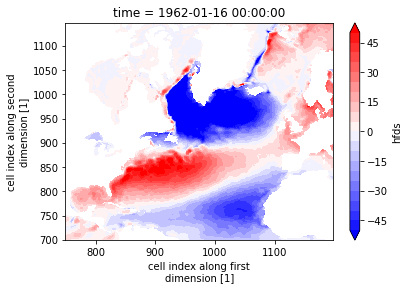

In [7]:
ds_NAOp['hfds'].isel(time=14).plot.contourf(vmin=-50, vmax=50, levels=21, cmap='bwr')

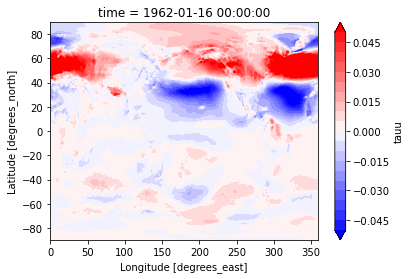

In [54]:
tauu_NAOp['tauu'].isel(time=14).plot.contourf(vmin=-0.05, vmax=0.05, levels=21, cmap='bwr')

#### Overturning Data

In [8]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl']

ds = xr.open_dataset(ppdir+"Overturning_z.nc", decode_times=False, chunks={'r':1, 'y':1})
ds = ds.get(var_list)
ds = xr.decode_cf(ds)

ppdir_drift="/gws/nopw/j04/snapdragon/hkhatri/Data_Drift/"

ds_drift = []

for lead_year in range(0, 11):
    
    d = xr.open_dataset(ppdir_drift + "diaptr/" + "Drift_diaptr_Lead_Year_" + 
                        str(lead_year + 1) + ".nc", decode_times= False)
    d = d.assign(time_counter = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time_counter'])), 1))
    
    ds_drift.append(d)
    
ds_drift = xr.concat(ds_drift, dim='time_counter')

ds_drift = ds_drift.get(var_list)

ds_anom = ds.drop('time_counter')  - ds_drift.drop(['time_counter','start_year'])

print(ds_anom)

<xarray.Dataset>
Dimensions:            (depthw: 75, y: 451, x: 1, start_year: 57, r: 10,
                        time_counter: 125)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 3.997 4.246 4.495 ... 79.85 79.92 79.99
    nav_lon            (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: y, x, r, time_counter
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, depthw, y, x) float32 dask.array<chunksize=(57, 1, 125, 75, 1, 1), meta=np.ndarray>


#### One DJF

This is for one DJF only

In [8]:
%%time
psiz_NAOp = (ds_anom['zomsfatl'].where(NAO_season.isel(time=tim_ind) 
                                        >= NAO_cut).mean(['start_year','r', 'x'])).compute()

psiz_NAOn = (ds_anom['zomsfatl'].where(NAO_season.isel(time=tim_ind) 
                                        <= -NAO_cut).mean(['start_year','r', 'x'])).compute()

#print(psiz_NAOp)

CPU times: user 4min 14s, sys: 27min 47s, total: 32min 1s
Wall time: 31min 10s


#### Multiple DJF

This is for multiple DJFs and then combine them together

In [10]:
psiz_NAOp = []
psiz_NAOn = []

for ind in range(4,13,4):

    c_NAOp = (xr.where(NAO_season.isel(time=ind) >= NAO_cut, 1, 0)).sum().values
    c_NAOn = (xr.where(NAO_season.isel(time=ind) <= -NAO_cut, 1, 0)).sum().values
    
    psip = (ds_anom['zomsfatl'].where(NAO_season.isel(time=ind) >= NAO_cut))
    psip = psip.isel(time_counter = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).sum(['start_year','r', 'x'])
    
    psiz_NAOp.append(psip)
    
    psip = (ds_anom['zomsfatl'].where(NAO_season.isel(time=ind) <= -NAO_cut))
    psip = psip.isel(time_counter = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).sum(['start_year','r', 'x'])
    
    psiz_NAOn.append(psip)

psiz_NAOp = xr.concat(psiz_NAOp, dim='ind')
psiz_NAOp = psiz_NAOp.sum('ind')/count_NAOp

psiz_NAOn = xr.concat(psiz_NAOn, dim='ind')
psiz_NAOn = psiz_NAOn.sum('ind')/count_NAOn

In [11]:
%time psiz_NAOp = psiz_NAOp.compute()
%time psiz_NAOn = psiz_NAOn.compute()

CPU times: user 2min 28s, sys: 17min 48s, total: 20min 16s
Wall time: 19min 25s
CPU times: user 2min 32s, sys: 15min 24s, total: 17min 56s
Wall time: 16min 57s


### Animation

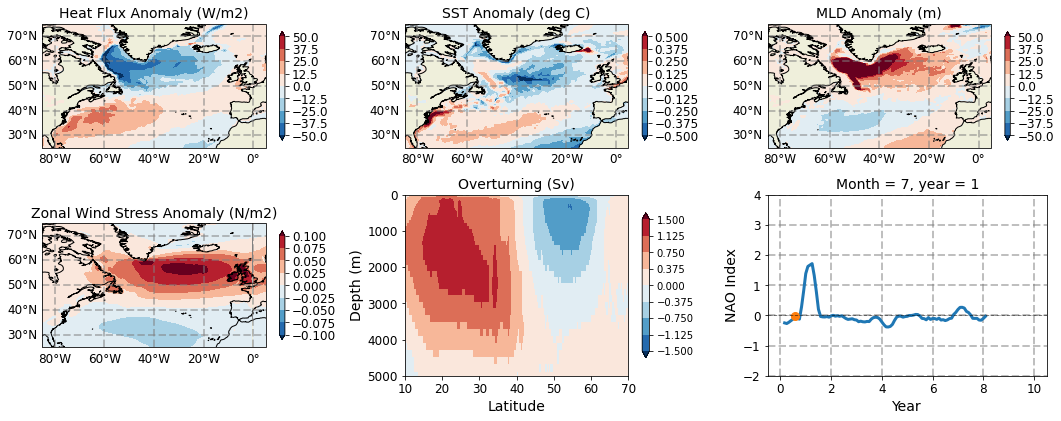

In [73]:
grid1 = plt.GridSpec(2, 3, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[18,7])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = ['Heat Flux Anomaly (W/m2)', 'SST Anomaly (deg C)' , 'MLD Anomaly (m)', 'Zonal Wind Stress Anomaly (N/m2)']
val = [50., 0.5, 50., 0.1]

lat_lon_ext = [-85., 5., 25., 75.]

count = 0
axs = []
cbs = []
for var in var_list:
    
    ax = fig.add_subplot(grid1[0, count], projection=ccrs.PlateCarree(),facecolor='grey')
    
    titl = str(name[count])
    
    tmp = ds_NAOp[var].rolling(time=6, center=True).mean('time').isel(time=14)
    
    [p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                    lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[count]))
    
    count = count + 1
    
    axs.append(ax)
    cbs.append(cb)
    
ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')

titl = str(name[3])
tmp = tauu_NAOp['tauu'].rolling(time=6, center=True).mean('time').isel(time=14)

[p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
             lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))

axs.append(ax)
cbs.append(cb)

ax = fig.add_subplot(grid1[1, 1])
    
tmp = psiz_NAOp.rolling(time_counter=6, center=True).mean('time_counter').isel(time_counter=12)
tmp = tmp.assign_coords(y=ds_anom.nav_lat.isel(x=0), time_counter=20)
p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-1.5, vmax=1.5, levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8) 
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
ax.set_ylim([0., 5000.])
ax.set_xlim([10., 70.])
plt.gca().invert_yaxis()
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

axs.append(ax)
cbs.append(cb)

ax = fig.add_subplot(grid1[1, 2])
titl = ('Month = ' + str(ds_NAOp['time.month'].isel(time=20).values) + ', year = ' + 
        str(ds_NAOp['time.year'].isel(time=20).values -1961))

# the below code is for specfiic DJF extreme
#tmp = NAOp.mean(['start_year','r'])
#tmp_std = NAOp.std(['start_year','r'])
#count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
#count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)

# the below code is for combining multiple DJF extreme while maintaining the timelag
tmp = []
for ind in range(4,13,4):
    
    tmp1 = ds_NAO['NAO'].where(NAO_season.isel(time=ind).drop('time') >= NAO_cut)
    tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).sum(['start_year','r'])
    
    tmp.append(tmp1)

#tmp_std = tmp.std(['start_year','r'])
tmp = sum(tmp) / count_NAOp
tmp = tmp.rolling(time=6, center=True).mean('time')

N = count_NAOp #.sum().values # 7 days decorrelation time
ci = 1.96 # coefficiet for large N and 95% confidence interval


std_err = (ci/np.sqrt(np.ceil(N)))
tim = (ds_NAOp['time.month'].isel(time=slice(0,10+1)).values/12 
        + ds_NAOp['time.year'].isel(time=slice(0,10+1)).values -1961)

ax.plot(ds_NAOp['time.month'].values/12 + ds_NAOp['time.year'].values -1961, tmp, lw=3.)
#ax.fill_between(ds_NAOp['time.month'].values/12 + ds_NAOp['time.year'].values - 1961, 
#                (tmp.values - std_err*tmp_std.values), 
#                    (tmp.values + std_err*tmp_std.values), alpha=0.3)
ax.plot(tim[-3], tmp.values[-3], 'o', ms=8)
ax.set_ylabel('NAO Index', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title(titl, fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_ylim([-2., 4.])
ax.set_xlim([-0.5, 10.5])
ax.axhline(y=0, ls='-.', lw=0.5, color='k')
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)

axs.append(ax)

#axs[4].remove()
#cbs[4].remove()

In [11]:
%%time

# Now use 6-month rolling window to see the ternd in a better way

#case = 'NAOp'
case = 'NAOn'

# Define the meta data for the movie
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='NAO, Winds, SST, Heat flux', artist='Matplotlib',
                comment='Surface anomaly fields from DePreSys4 Met Office output')
writer = FFMpegWriter(fps=3, metadata=metadata)

grid1 = plt.GridSpec(2, 3, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[18,7])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = ['Heat Flux Anomaly (W/m2)', 'SST Anomaly (deg C)' , 'MLD Anomaly (m)', 'Zonal Wind Stress Anomaly (N/m2)']
val = [50., 0.5, 50., 0.1]

lat_lon_ext = [-85., 5., 25., 75.]

# the below code is for specfiic DJF extreme
#count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0).sum().values
#count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0).sum().values

if (case == 'NAOp'):
    #N = count_NAOp.sum().values
    N = count_NAOp
elif(case == 'NAOn'):
    #N = count_NAOn.sum().values
    N = count_NAOn
else:
    print('Choose valid case')
    
ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))

fig.patch.set_facecolor('white')

#file_name = "/home/users/hkhatri/Plots/Animations/" + case + "_JFM_ind_" + str(tim_ind) + "_Composite.mp4"
file_name = "/home/users/hkhatri/Plots/Animations/" + case + "_JFM_ind_4812_Composite.mp4"

with writer.saving(fig, file_name, 300): # set dpi
    
    for i in range(0+3, len(ds_NAOp.time)-3):
        
        #print(ds_NAOp['time.year'].values[i])
        
        axs = []
        cbs = []
        
        count = 0
        for var in var_list:

            ax = fig.add_subplot(grid1[0, count], projection=ccrs.PlateCarree(),facecolor='grey')

            titl = str(name[count])

            if (case == 'NAOp'):
                #tmp = ds_NAOp[var].rolling(time=4, center=True).mean().isel(time=i)
                tmp = (ds_NAOp[var].rolling(time=6, center=True).mean('time')).isel(time=i)
            elif(case == 'NAOn'):
                #tmp = ds_NAOn[var].isel(time=i)
                tmp = (ds_NAOn[var].rolling(time=6, center=True).mean('time')).isel(time=i)

            [p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                            lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[count]))

            count = count + 1
            
            axs.append(ax)
            cbs.append(cb)

        ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')

        titl = str(name[3])
        
        if (case == 'NAOp'):
            #tmp = tauu_NAOp['tauu'].isel(time=i)
            tmp = (tauu_NAOp['tauu'].rolling(time=6, center=True).mean('time')).isel(time=i)
        elif(case == 'NAOn'):
            #tmp = tauu_NAOn['tauu'].isel(time=i)
            tmp = (tauu_NAOn['tauu'].rolling(time=6, center=True).mean('time')).isel(time=i)

        [p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                     lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))
        
        axs.append(ax)
        cbs.append(cb)
        
        ax = fig.add_subplot(grid1[1, 1])
        
        if (case == 'NAOp'):
            #tmp = psiz_NAOp.isel(time_counter=i)
            tmp = (psiz_NAOp.rolling(time_counter=6, center=True).mean('time_counter')).isel(time_counter=i)
        elif(case == 'NAOn'):
            #tmp = psiz_NAOn.isel(time_counter=i)
            tmp = (psiz_NAOn.rolling(time_counter=6, center=True).mean('time_counter')).isel(time_counter=i)
            
        tmp = tmp.assign_coords(y=ds_anom.nav_lat.isel(x=0), time_counter=0)
        p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-1.5, vmax=1.5, levels = 9, 
                    cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8) 
        ax.set_ylabel('Depth (m)', fontsize=14)
        ax.set_xlabel('Latitude', fontsize=14)
        plt.xticks(np.arange(20,70,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
        ax.set_ylim([0., 5000.])
        ax.set_xlim([10., 70.])
        plt.gca().invert_yaxis()
        plt.title('Overturning Anomaly (Sv)', fontsize=14)
        plt.yticks(fontsize = 12)
        plt.xticks(fontsize = 12)

        axs.append(ax)
        cbs.append(cb)
        
        ax = fig.add_subplot(grid1[1, 2])

        titl = ('Month = ' + str(ds_NAOp['time.month'].isel(time=i).values) + 
                ', year = ' + str(ds_NAOp['time.year'].isel(time=i).values -1961))
        
        if (case == 'NAOp'):
            #tmp = NAOp.isel(time=slice(0,i+1)).mean(['start_year','r'])
            #tmp_std = NAOp.isel(time=slice(0,i+1)).std(['start_year','r'])
            
            tmp = []
            for ind in range(4,13,4):

                tmp1 = ds_NAO['NAO'].where(NAO_season.isel(time=ind).drop('time') >= NAO_cut)
                tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).sum(['start_year','r'])

                tmp.append(tmp1)

            #tmp_std = tmp.std(['start_year','r'])
            tmp = sum(tmp) / count_NAOp
            tmp = tmp.rolling(time=6, center=True).mean('time')
            tmp = tmp.isel(time=slice(0,i+1))

        elif(case == 'NAOn'):
            #tmp = NAOn.isel(time=slice(0,i+1)).mean(['start_year','r'])
            #tmp_std = NAOn.isel(time=slice(0,i+1)).std(['start_year','r'])
            
            tmp = []
            for ind in range(4,13,4):

                tmp1 = ds_NAO['NAO'].where(NAO_season.isel(time=ind).drop('time') <= -NAO_cut)
                tmp1 = tmp1.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).sum(['start_year','r'])

                tmp.append(tmp1)

            #tmp_std = tmp.std(['start_year','r'])
            tmp = sum(tmp) / count_NAOp
            tmp = tmp.rolling(time=6, center=True).mean('time')
            tmp = tmp.isel(time=slice(0,i+1))
            
        
        tim = (ds_NAOp['time.month'].isel(time=slice(0,i+1)).values/12 
               + ds_NAOp['time.year'].isel(time=slice(0,i+1)).values -1961)

        ax.plot(tim, tmp, lw=3.)
        #ax.fill_between(tim, (tmp.values - std_err*tmp_std.values), 
        #                    (tmp.values + std_err*tmp_std.values), alpha=0.3)
        ax.plot(tim[-1], tmp.values[-1], 'o', ms=7)
        ax.set_ylabel('NAO Index', fontsize=14)
        ax.set_xlabel('Year', fontsize=14)
        ax.set_title(titl, fontsize=14)
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        if (case == 'NAOp'):
            ax.set_ylim([-1., 2.5])
        elif(case == 'NAOn'):
            ax.set_ylim([-2.5, 1.])
        ax.set_xlim([-0.5, 10.5])
        ax.axhline(y=0, ls='-.', lw=0.5, color='k')
        ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
        
        axs.append(ax)
        
        plt.tight_layout();
        
        writer.grab_frame();
        
        for ax1 in axs:
            ax1.remove();
        for cb1 in cbs:
            cb1.remove();

CPU times: user 10min 15s, sys: 10min 8s, total: 20min 24s
Wall time: 17min 40s


<Figure size 1296x504 with 0 Axes>

### Plot for Feb 2022 report

DJF anomalies corresponding to NAO+ and NAO- phases

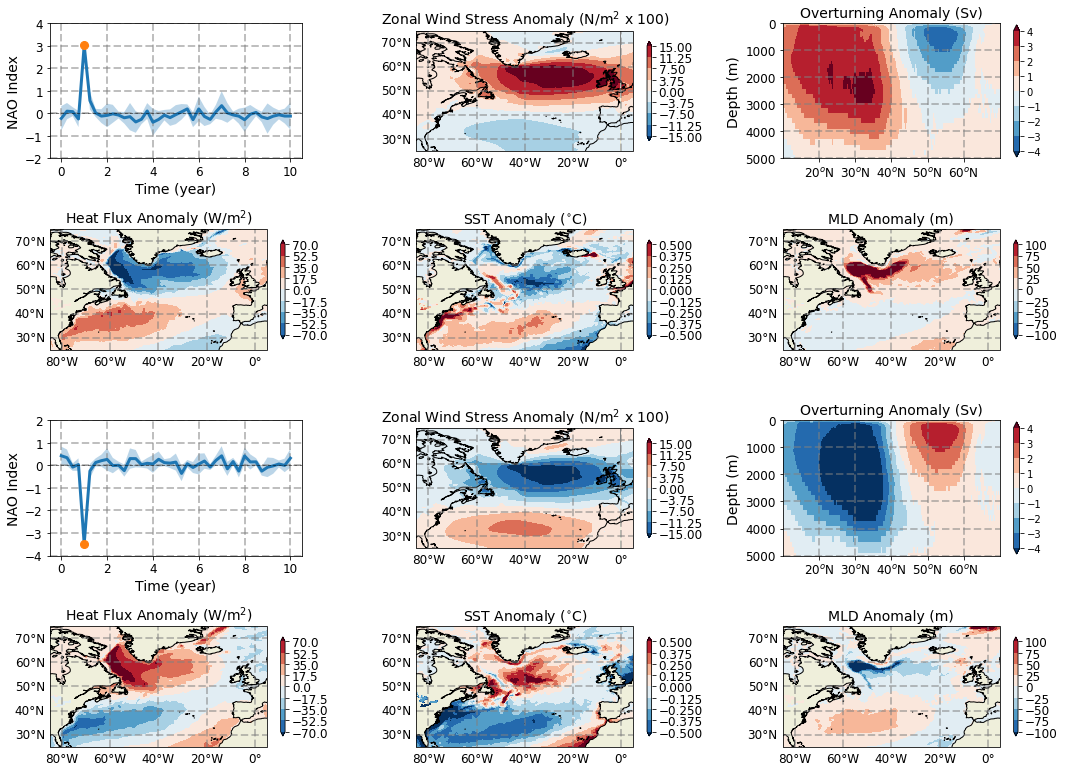

In [18]:
tim_ind =4

grid1 = plt.GridSpec(4, 3, wspace=0.35, hspace=0.2)
fig = plt.figure(figsize=[18,14])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = [r'Heat Flux Anomaly (W/m$^2$)', r'SST Anomaly ($^{\circ}$C)' , 'MLD Anomaly (m)', r'Zonal Wind Stress Anomaly (N/m$^2$ x 100)']
val = [70., 0.5, 100., 15]

lat_lon_ext = [-85., 5., 25., 75.]

case_list = ['NAOp', 'NAOn']

for case in case_list: 

    count = 0

    for var in var_list:

        titl = str(name[count])
        
        # get seasonl mean for the relavant data
        if (case == 'NAOp'):
            ax = fig.add_subplot(grid1[1, count], projection=ccrs.PlateCarree(),facecolor='grey')
            tmp = ds_NAOp[var].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')
        elif(case == 'NAOn'):
            ax = fig.add_subplot(grid1[3, count], projection=ccrs.PlateCarree(),facecolor='grey')
            tmp = ds_NAOn[var].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')
            
        [p, cb] = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                        lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[count]))

        count = count + 1

    titl = str(name[3])
    
    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
        tmp = tauu_NAOp['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
        tmp = tauu_NAOn['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')

    [p, cb] = plot_sec(ax, tmp*100, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                 lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))

    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[0, 2])
        tmp = psiz_NAOp.isel(time_counter=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time_counter')
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[2, 2])
        tmp = psiz_NAOn.isel(time_counter=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time_counter')
        
    tmp = tmp.assign_coords(y=ds_anom.nav_lat.isel(x=0), time_counter=20)
    p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-4.0, vmax=4.0, levels = 9, 
                cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8) 
    ax.set_ylabel('Depth (m)', fontsize=14)
    #ax.set_xlabel('Latitude', fontsize=14)
    plt.xticks(np.arange(20,70,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
    ax.set_ylim([0., 5000.])
    ax.set_xlim([10., 70.])
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    plt.gca().invert_yaxis()
    plt.title('Overturning Anomaly (Sv)', fontsize=14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
    bbox=plt.gca().get_position()
    offset=.03
    plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5 , bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])

    if (case == 'NAOp'):
        ax = fig.add_subplot(grid1[0, 0])
        tmp = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut)
        count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
        N = count_NAOp.sum().values # 7 days decorrelation time
    elif(case == 'NAOn'):
        ax = fig.add_subplot(grid1[2, 0])
        tmp = NAO_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut)
        count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)
        N = count_NAOn.sum().values # 7 days decorrelation time
    
    tmp_std = tmp.std(['start_year','r'])
    tmp = tmp.mean(['start_year','r'])

    ci = 1.96 # coefficiet for large N and 95% confidence interval
    std_err = (ci/np.sqrt(np.ceil(N)))
    
    tim = np.arange(0,41)

    ax.plot(tim / 4, tmp, lw=3.)
    ax.fill_between(tim / 4, (tmp.values - std_err*tmp_std.values), (tmp.values + std_err*tmp_std.values), alpha=0.3)
    ax.plot(tim[tim_ind] / 4, tmp.values[tim_ind], 'o', ms=8)
    ax.set_ylabel('NAO Index', fontsize=14)
    ax.set_xlabel('Time (year)', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    if (case == 'NAOp'):
        ax.set_ylim([-2., 4.])
    elif(case == 'NAOn'):
        ax.set_ylim([-4., 2.])
    ax.set_xlim([-0.5, 10.5])
    ax.axhline(y=0, ls='-.', lw=0.5, color='k')
    ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    
    bbox=plt.gca().get_position()
    offset=.03
    plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5 , bbox.x1-bbox.x0 - offset*0.5, bbox.y1 - bbox.y0 - offset])

fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Snapshot_NAO_Heat_Flux_SST_Overturning.pdf',dpi=150,bbox_inches='tight');
#fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Snapshot_NAO_Heat_Flux_SST_Overturning.eps',dpi=150,bbox_inches='tight');

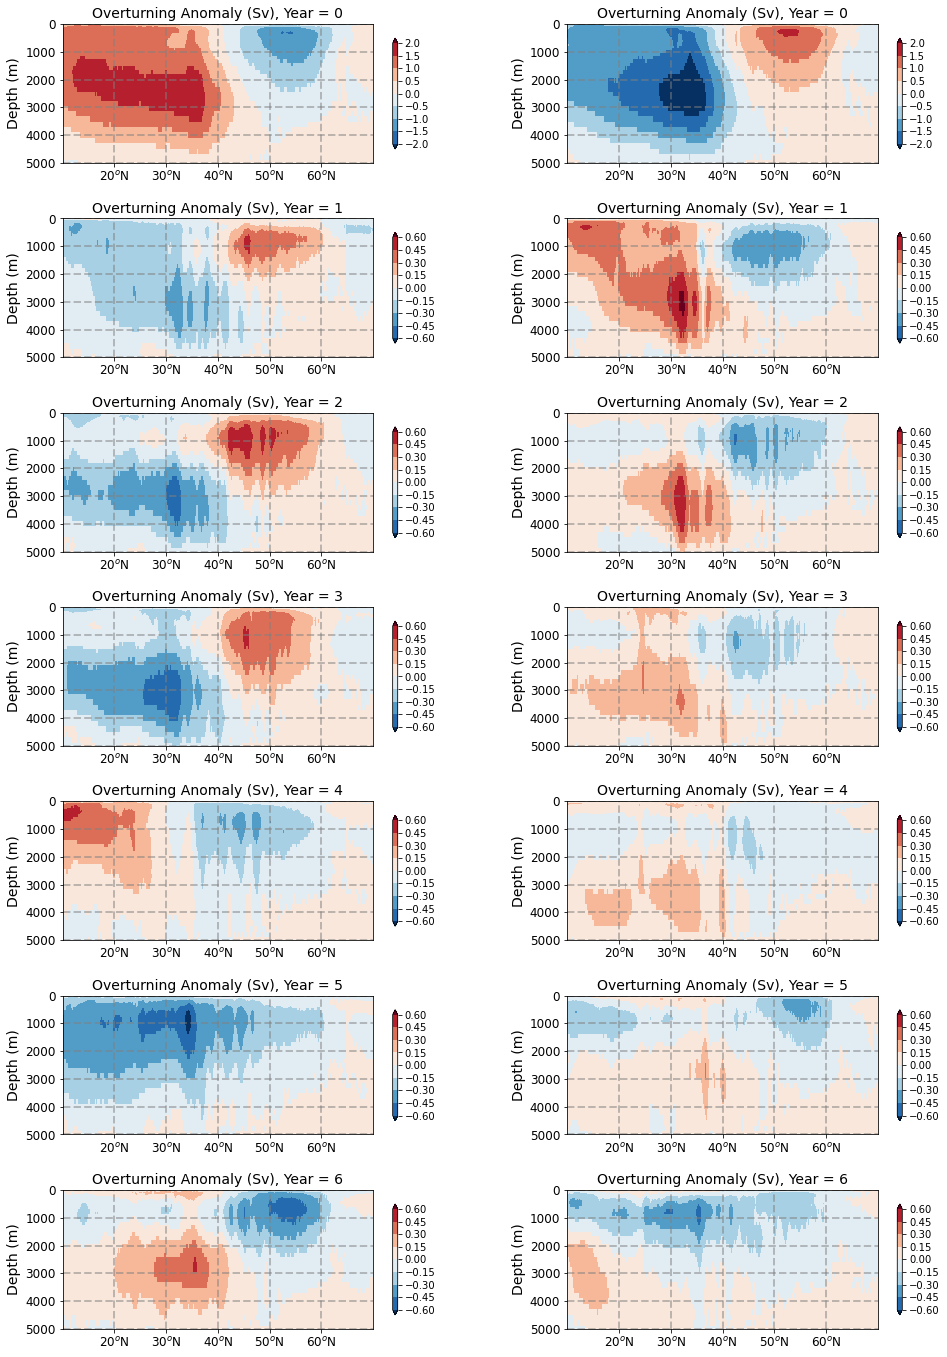

In [35]:
grid1 = plt.GridSpec(7, 2, wspace=0.3, hspace=0.4)
fig = plt.figure(figsize=[16,24])

case_list = ['NAOp', 'NAOn']

for case in case_list: 
    
    for i in range(1,8):
        
        tim_ind = 4 + i*4

        if (case == 'NAOp'):
            ax = fig.add_subplot(grid1[i-1, 0])
            tmp = psiz_NAOp.isel(time_counter=slice(12*i, 12*i + 8)).mean('time_counter')
        elif(case == 'NAOn'):
            ax = fig.add_subplot(grid1[i-1, 1])
            tmp = psiz_NAOn.isel(time_counter=slice(12*i, 12*i + 8)).mean('time_counter')
        
        if(i==1):
            rang_val = 2.0
        else:
            rang_val = 0.6
        
        tmp = tmp.assign_coords(y=ds_anom.nav_lat.isel(x=0), time_counter=20)
        p = tmp.plot(ax=ax, x='nav_lat', y='depthw', levels = 9, vmin = -rang_val, vmax = rang_val,
                    cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
        cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8) 
        ax.set_ylabel('Depth (m)', fontsize=14)
        #ax.set_xlabel('Latitude', fontsize=14)
        plt.xticks(np.arange(20,70,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
        ax.set_ylim([0., 5000.])
        ax.set_xlim([10., 70.])
        ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
        plt.gca().invert_yaxis()
        plt.title('Overturning Anomaly (Sv), Year = ' + str(i-1), fontsize=14)
        plt.yticks(fontsize = 12)
        plt.xticks(fontsize = 12)
        
fig.savefig('/home/users/hkhatri/Plots/Figures_EGU_2022/Snapshot_Overturning_Depth.pdf',dpi=150,bbox_inches='tight');

### Combine data for heat flux extremes with multiple DJF season

For better stats, we isolate members that had heat flux anomalies >=50. (<=-50.) in Irminger Sea at tim_ind = 4, 8, 12. We then combine them together (with shifted timelines, so heat flux extremes are aligned) and consider only years -1 to 7.

In [6]:
ppdir_NAO="/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"
year1, year2 = (1960, 2017)

ds_NAO = xr.open_dataset(ppdir_NAO + "NAO_SLP_Anomaly.nc")

NAO = ds_NAO['NAO']
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO = NAO.assign_coords(time=tim)
NAO = NAO.chunk({'start_year':-1, 'r':1, 'time':1})

NAO = NAO.isel(time=slice(1,len(NAO.time)-1)) # get rid of first Nov and last Mar for seasonal avg
NAO_season = NAO.resample(time='QS-DEC').mean('time')

ds_hfds = []
    
for i in range(0,10):
    
    d = xr.open_dataset(ppdir_NAO + "../Area_mean_timeseries/Anomaly_hfds_r" + str(i+1) + ".nc")
        
    ds_hfds.append(d)
    
ds_hfds = xr.concat(ds_hfds, dim='r')

ds_hfds = ds_hfds.assign_coords(time=tim)
ds_hfds = ds_hfds.assign(start_year = np.arange(year1, year2, 1))

HF_Irm = ds_hfds['Irminger_Sea'].isel(time=slice(1,len(ds_hfds.time)-1))
HF_Irm_season = HF_Irm.resample(time='QS-DEC').mean('time')

print(HF_Irm_season)

<xarray.DataArray 'Irminger_Sea' (r: 10, start_year: 57, time: 41)>
array([[[ 4.33318367e+01, -8.44222069e+00, -7.09477234e+00, ...,
         -1.49850616e+01, -3.59237251e+01, -1.95638828e+01],
        [-1.81945744e+01, -3.36976051e+01, -1.32485952e+01, ...,
         -1.17331610e+01,  1.66744995e+01, -1.61345692e+01],
        [-4.54024849e+01, -2.18135509e+01, -2.90824032e+01, ...,
         -8.14380944e-01, -3.13251019e+01,  4.84237146e+00],
        ...,
        [ 3.79745522e+01,  2.56319904e+01,  5.74650717e+00, ...,
          8.87178230e+00,  1.60373249e+01, -2.58793240e+01],
        [ 1.50121820e+00,  3.39330711e+01,  6.74005651e+00, ...,
          9.11222172e+00,  1.35946960e+01,  1.69298439e+01],
        [-1.94922791e+01,  1.69236107e+01,  1.24213228e+01, ...,
          1.13097162e+01,  5.06787605e+01, -5.58411074e+00]],

       [[ 8.75389862e+00, -1.42863587e-01,  7.49215555e+00, ...,
         -2.99708691e+01,  5.24669218e+00, -7.22214365e+00],
        [ 1.18529558e+01,  2.284665

In [9]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/time_series/hfds_Irminger/"

ds_HFp = []
ds_HFn = []
tauu_HFp = []
tauu_HFn = []

var_list = ['tos', 'hfds', 'mlotst']
var_list_atmos = ['tauu']

HF_cut = 50.

count_HFp = 0
count_HFn = 0

HF_season = HF_Irm_season

for ind in range(4,13,4):
    
    c_HFp = (xr.where(HF_season.isel(time=ind) >= HF_cut, 1, 0)).sum().values
    c_HFn = (xr.where(HF_season.isel(time=ind) <= -HF_cut, 1, 0)).sum().values
    
    count_HFp =  count_HFp + c_HFp
    count_HFn =  count_HFn + c_HFn
    
    d_HFp = xr.open_mfdataset(ppdir + "*HFp*ind_" + str(ind) + ".nc")
    d_HFp = d_HFp.get(var_list)
    d_HFp = d_HFp.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_HFp
    
    tau_HFp = xr.open_mfdataset(ppdir + "*HFp_tauu*ind_" + str(ind) + ".nc")
    tau_HFp = tau_HFp.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_HFp
    
    #d_HFn = xr.open_mfdataset(ppdir + "*HFn*ind_" + str(ind) + ".nc")
    #d_HFn = d_HFn.get(var_list)
    #d_HFn = d_HFn.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_HFn
    
    #tau_HFn = xr.open_mfdataset(ppdir + "*HFn_tauu*ind_" + str(ind) + ".nc")
    #tau_HFn = tau_HFn.isel(time = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5))  * c_HFn
    
    if(ind > 4):
        #d_HFn = d_HFn.drop('time')
        d_HFp = d_HFp.drop('time')
        #tau_HFn = tau_HFn.drop('time')
        tau_HFp = tau_HFp.drop('time')
    
    ds_HFp.append(d_HFp)
    #ds_HFn.append(d_HFn)
    #tauu_HFn.append(tau_HFn)
    tauu_HFp.append(tau_HFp)
    
    print(count_HFp, count_HFn)

ds_HFp = sum(ds_HFp)/count_HFp
#ds_HFn = sum(ds_HFn)/count_HFn
tauu_HFp = sum(tauu_HFp)/count_HFp
#tauu_HFn = sum(tauu_HFn)/count_HFn

21 22
39 51
58 83


In [11]:
psiz_HFp = []
#psiz_NAOn = []

for ind in range(4,13,4):

    c_HFp = (xr.where(HF_season.isel(time=ind) >= HF_cut, 1, 0)).sum().values
    c_HFn = (xr.where(HF_season.isel(time=ind) <= -HF_cut, 1, 0)).sum().values
    
    psip = (ds_anom['zomsfatl'].where(HF_season.isel(time=ind) >= HF_cut))
    psip = psip.isel(time_counter = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).sum(['start_year','r', 'x'])
    
    psiz_HFp.append(psip)
    
    #psip = (ds_anom['zomsfatl'].where(HF_season.isel(time=ind) <= -HF_cut))
    #psip = psip.isel(time_counter = slice((int(ind/4)-1)*12, (int(ind/4) + 7)*12 + 5)).sum(['start_year','r', 'x'])
    
    #psiz_HFn.append(psip)

psiz_HFp = xr.concat(psiz_HFp, dim='ind')
psiz_HFp = psiz_HFp.sum('ind')/count_HFp

#psiz_HFn = xr.concat(psiz_HFn, dim='ind')
#psiz_HFn = psiz_HFn.sum('ind')/count_HFn

In [12]:
%time psiz_HFp = psiz_HFp.compute()
#%time psiz_HFn = psiz_HFn.compute()

CPU times: user 2min 28s, sys: 17min 40s, total: 20min 9s
Wall time: 19min 21s


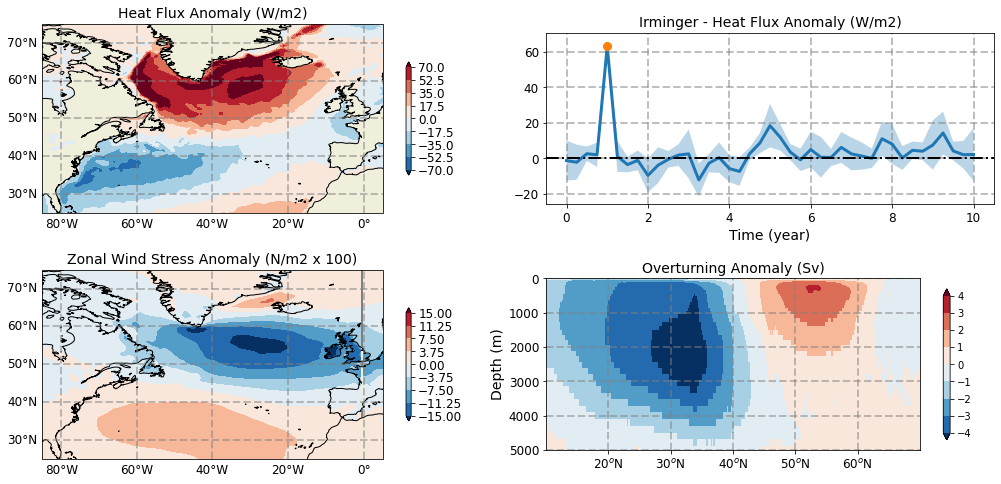

In [21]:
tim_ind = 4

grid1 = plt.GridSpec(2, 2, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[18,8])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = ['Heat Flux Anomaly (W/m2)', 'SST Anomaly (deg C)' , 'MLD Anomaly (m)', 'Zonal Wind Stress Anomaly (N/m2 x 100)']
val = [70., 0.5, 100., 15]

lat_lon_ext = [-85., 5., 25., 75.]

case_list = ['HFp', 'HFn']

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
tmp = ds_HFp['hfds'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')

[p, cb] = plot_sec(ax, tmp, vmin=-val[0], vmax=val[0],  lat_lon_ext = lat_lon_ext, levels = 9,
                        lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[0]))

ax = fig.add_subplot(grid1[0, 1])
tmp = HF_season.where(HF_season.isel(time=tim_ind) >= HF_cut)
count_HFp = xr.where(HF_season.isel(time=tim_ind) >= HF_cut, 1, 0)
N = count_HFp.sum().values # 7 days decorrelation time

tim = np.arange(0,41)

tmp_std = tmp.std(['start_year','r'])
tmp = tmp.mean(['start_year','r'])

ci = 1.96 # coefficiet for large N and 95% confidence interval
std_err = (ci/np.sqrt(np.ceil(N)))
    
ax.plot(tim / 4, tmp, lw=3.)
ax.fill_between(tim / 4, (tmp.values - std_err*tmp_std.values), 
                (tmp.values + std_err*tmp_std.values), alpha=0.3)
ax.plot(tim[tim_ind] / 4, tmp.values[tim_ind], 'o', ms=8)
plt.title('Irminger - Heat Flux Anomaly (W/m2)', fontsize=14)
ax.set_xlabel('Time (year)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#ax.set_ylim([-2., 4.])
ax.set_xlim([-0.5, 10.5])
ax.axhline(y=0, ls='-.', lw=2.0, color='k')
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
    
bbox=plt.gca().get_position()
offset=.03
plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5 , bbox.x1-bbox.x0 - offset*0.5, bbox.y1 - bbox.y0 - offset])

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
tmp = tauu_HFp['tauu'].isel(time=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time')

[p, cb] = plot_sec(ax, tmp*100, vmin=-val[3], vmax=val[3], lat_lon_ext = lat_lon_ext, levels = 9,
                 lon='lon', lat='lat', cmap='RdBu_r', title=str(name[3]))

ax = fig.add_subplot(grid1[1, 1])
tmp = psiz_HFp.isel(time_counter=slice(4*(tim_ind-1)+1, 4*(tim_ind-1)+1+3)).mean('time_counter')

tmp = tmp.assign_coords(y=ds_anom.nav_lat.isel(x=0))
p = tmp.plot(ax=ax, x='nav_lat', y='depthw', vmin=-4.0, vmax=4.0, levels = 9, 
            cmap='RdBu_r', add_labels=False, add_colorbar=False, extend='both')
cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8) 
ax.set_ylabel('Depth (m)', fontsize=14)
    #ax.set_xlabel('Latitude', fontsize=14)
plt.xticks(np.arange(20,70,10), [r'$20^o$N', r'$30^o$N', r'$40^o$N', r'$50^o$N', r'$60^o$N'])
ax.set_ylim([0., 5000.])
ax.set_xlim([10., 70.])
ax.grid(color='gray', alpha=0.5, linestyle='--', lw=2.)
plt.gca().invert_yaxis()
plt.title('Overturning Anomaly (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
    
bbox=plt.gca().get_position()
offset=.03
plt.gca().set_position([bbox.x0 , bbox.y0 + offset*0.5 , bbox.x1-bbox.x0, bbox.y1 - bbox.y0 - offset])